In [82]:
from meteostat import Stations, Monthly
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

print_distribution = False

In [41]:
# Retrieve all Meteostat weather stations
stations = Stations()

# Fetch the list of all stations
# Convert the result to a DataFrame
df_stations = stations.fetch()
df_stations = df_stations.reset_index()

In [42]:
print(f'data contains {df_stations.shape[0]} stations')
print(f'oft {df_stations.shape[1]} parameters each')
print('----------------')
display(df_stations.head(3))

data contains 15791 stations
oft 16 parameters each
----------------


,id,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
0,00FAY,Holden Agdm,CA,AB,71227,CXHD,53.1900,-112.2500,688.0,America/Edmonton,2020-01-01,2024-10-27,2002-11-01,2024-03-13,2003-01-01,2022-01-01
1,00TG6,Athabasca 1,CA,AB,<NA>,<NA>,54.7200,-113.2900,515.0,America/Edmonton,NaT,NaT,2000-01-01,2022-07-12,2000-01-01,2010-01-01
2,01001,Jan Mayen,NO,<NA>,01001,ENJA,70.9333,-8.6667,10.0,Europe/Oslo,1931-01-01,2024-08-20,1921-12-31,2024-10-21,1922-01-01,2022-01-01


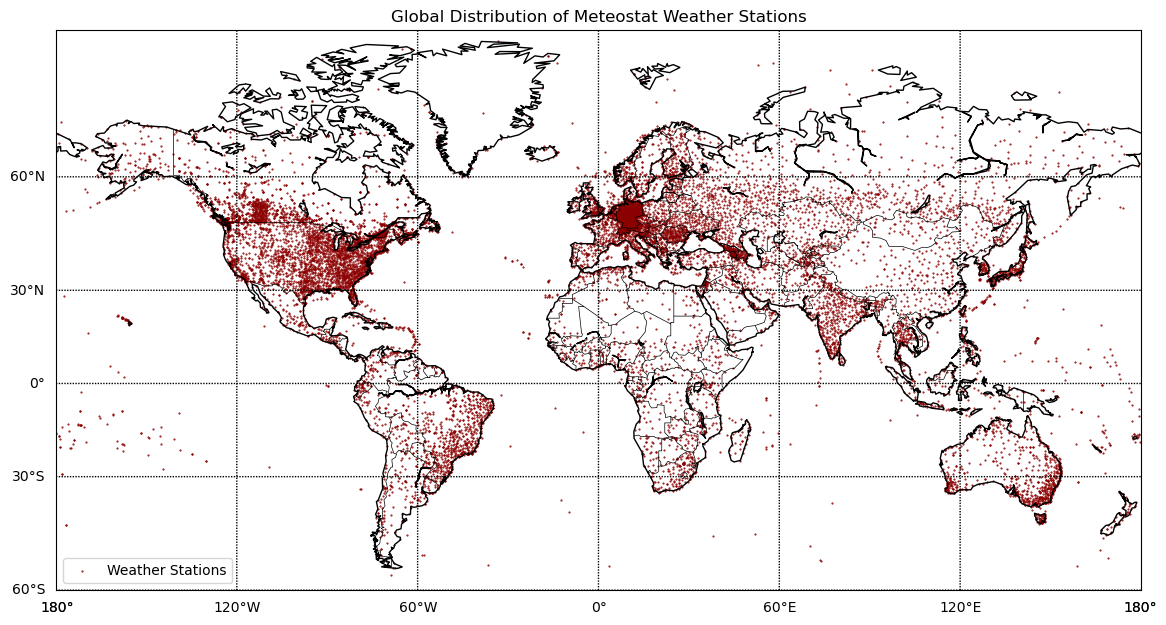

In [32]:
# Create the Basemap figure
plt.figure(figsize=(14, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=85, llcrnrlon=-180, urcrnrlon=180, resolution='c')

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawparallels(range(-90, 91, 30), labels=[1, 0, 0, 0])
m.drawmeridians(range(-180, 181, 60), labels=[0, 0, 0, 1])

# Extract latitude and longitude from the DataFrame
lats = df_stations['latitude'].values
lons = df_stations['longitude'].values

# Convert latitude and longitude to map projection coordinates
x, y = m(lons, lats)

# Plot the stations as red dots
m.scatter(x, y, s=1, color='darkred', alpha=1, marker='.', label='Weather Stations')

# Add a legend and title
plt.legend(loc='lower left')
plt.title('Global Distribution of Meteostat Weather Stations')

# Show the plot
if print_distribution:
    plt.show();
else: 
    plt.close();

In [149]:
from datetime import datetime

def adjust_dates_for_full_years(start, end):
    # Check for NaN values and handle them
    if pd.isna(start) or pd.isna(end):
        return None, None

    # Convert to datetime if not already
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    # Adjust start to the next January 1st if not already on that date
    if start.month != 1 or start.day != 1:
        start = datetime(start.year + 1, 1, 1)

    # Adjust end to the previous December 31st if not already on that date
    if end.month != 12 or end.day != 31:
        end = datetime(end.year - 1, 12, 31)

    # Ensure start is before or the same as end
    if start > end:
        return None, None

    return start, end


In [151]:
# Fetch all the bulk data for all the stations and calculate the yearly averages
fetch_data = False
df_meta = pd.DataFrame()

# Loop through individual stations
for i, row in df_stations.iterrows():
    station_id = row["id"]
    name = row["name"]
    country = row["country"]

    print(f"{station_id} | {name} | {country}:")

    # Get station parameters
    start_i = row["monthly_start"]
    end_i = row["monthly_end"]

    # Adjust the dates to only take full years into account
    start_i_adj, end_i_adj = adjust_dates_for_full_years(start_i, end_i)

    # Check if the adjusted dates are valid (not None)
    if start_i_adj is None or end_i_adj is None:
        print(f"Invalid date range for station {station_id}. Skipping...")
        continue

    # Log adjustments, if any
    if start_i != start_i_adj:
        print(f"Recording START was adjusted from {start_i} to {start_i_adj}")
    else:
        print(f"Recording START {start_i_adj}")
        
    if end_i != end_i_adj:
        print(f"Recording END was adjusted from {end_i} to {end_i_adj}")
    else:
        print(f"Recording END {end_i_adj}")

    # Calculate the number of extracted months
    extracted_months = (end_i_adj.year - start_i_adj.year) * 12 + (end_i_adj.month - start_i_adj.month)
    print(f"Extracting {extracted_months} months")

    # Fetch data if the flag is set to True
    if fetch_data:
        # Fetch data for station 'station_id' from 'start_i_adj' to 'end_i_adj'
        data_i = Monthly(
            station_id,
            start=pd.to_datetime(start_i_adj, format='%Y-%m-%d'),
            end=pd.to_datetime(end_i_adj, format='%Y-%m-%d')
        )

    print('------')

    # Create a DataFrame for the station metadata
    df_i = pd.DataFrame({
        "id": [station_id],
        "name": [name],
        "country": [country],
        "start": [start_i_adj],
        "end": [end_i_adj],
        "n_months": [extracted_months]
    })

    # Concatenate the station metadata to the main DataFrame
    df_meta = pd.concat([df_meta, df_i], ignore_index=True)


00FAY | Holden Agdm | CA:
Recording START 2003-01-01 00:00:00
Recording END was adjusted from 2022-01-01 00:00:00 to 2021-12-31 00:00:00
Extracting 227 months
------
00TG6 | Athabasca 1 | CA:
Recording START 2000-01-01 00:00:00
Recording END was adjusted from 2010-01-01 00:00:00 to 2009-12-31 00:00:00
Extracting 119 months
------
01001 | Jan Mayen | NO:
Recording START 1922-01-01 00:00:00
Recording END was adjusted from 2022-01-01 00:00:00 to 2021-12-31 00:00:00
Extracting 1199 months
------
01002 | Grahuken | NO:
Invalid date range for station 01002. Skipping...
01003 | Hornsund | NO:
Recording START 2016-01-01 00:00:00
Recording END was adjusted from 2017-01-01 00:00:00 to 2016-12-31 00:00:00
Extracting 11 months
------
01004 | New Alesund II | NO:
Recording START 1969-01-01 00:00:00
Recording END was adjusted from 1974-01-01 00:00:00 to 1973-12-31 00:00:00
Extracting 59 months
------
01005 | Barentsburg | NO:
Recording START 1951-01-01 00:00:00
Recording END was adjusted from 1980-0

In [161]:
df_meta

,id,name,country,start,end,n_months
0,00FAY,Holden Agdm,CA,2003-01-01,2021-12-31,227
1,00TG6,Athabasca 1,CA,2000-01-01,2009-12-31,119
2,01001,Jan Mayen,NO,1922-01-01,2021-12-31,1199
3,01003,Hornsund,NO,2016-01-01,2016-12-31,11
4,01004,New Alesund II,NO,1969-01-01,1973-12-31,59
...,...,...,...,...,...,...
12446,ZWWW0,Diwopu / Urumqi / Dihua,CN,2006-01-01,2021-12-31,191
12447,ZX07Q,Okotoks,CA,2000-01-01,2020-12-31,251
12448,ZXYDC,Bonavista,CA,2006-01-01,2021-12-31,191
12449,ZYC17,Kingston Airport,CA,2019-01-01,2021-12-31,35


In [159]:
print(f'total amount of months {sum(df_meta["n_months"]/1000000)} M')
print(f'min starting {min(df_meta["start"])}')
print(f'max starting {max(df_meta["start"])}')

total amount of months 6.357941 M
min starting 1781-01-01 00:00:00
max starting 2021-01-01 00:00:00


In [154]:
df_meta.head(20)

,id,name,country,start,end,n_months
0,00FAY,Holden Agdm,CA,2003-01-01,2021-12-31,227
1,00TG6,Athabasca 1,CA,2000-01-01,2009-12-31,119
2,01001,Jan Mayen,NO,1922-01-01,2021-12-31,1199
3,01003,Hornsund,NO,2016-01-01,2016-12-31,11
4,01004,New Alesund II,NO,1969-01-01,1973-12-31,59
5,01005,Barentsburg,NO,1951-01-01,1979-12-31,347
6,01007,New Alesund,NO,1974-01-01,2021-12-31,575
7,01008,Svalbard Lufthavn,NO,1975-01-01,2021-12-31,563
8,01015,Hekkingen Lighthouse,NO,1979-01-01,2020-12-31,503
9,01025,Tromso Airport,NO,1964-01-01,2021-12-31,695
